Подготовка данных к обучению

In [79]:
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm
import os
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

In [80]:
df = pd.read_csv("/content/cybersequrity.csv")
df.head()

,svcscan.fs_drivers,callbacks.ngeneric,psxview.not_in_eprocess_pool_false_avg,psxview.not_in_eprocess_pool,callbacks.nanonymous,psxview.not_in_session,psxview.not_in_pslist,psxview.not_in_pspcid_list,psxview.not_in_ethread_pool,psxview.not_in_csrss_handles,psxview.not_in_pslist_false_avg,psxview.not_in_pspcid_list_false_avg,psxview.not_in_deskthrd,psxview.not_in_ethread_pool_false_avg,psxview.not_in_session_false_avg,Class
0,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,6,0.000000,0.044444,1
1,26,8,0.0,0,0,5,3,3,3,7,0.073171,0.073171,9,0.073171,0.121951,1
2,26,8,0.0,0,0,9,7,7,7,11,0.152174,0.152174,13,0.152174,0.195652,1
3,26,8,0.0,0,0,3,1,1,2,6,0.022222,0.022222,9,0.044444,0.066667,1
4,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,6,0.000000,0.048780,0


In [81]:
X = df.drop('Class', axis=1)
y = df['Class']

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42,
    shuffle=True
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.25,
    stratify=y_train_val,
    random_state=42,
    shuffle=True
)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Размер обучающей выборки: {X_train_scaled.shape} ({len(X_train_scaled)/len(X)*100:.1f}%)")
print(f"Размер валидационной выборки: {X_val_scaled.shape} ({len(X_val_scaled)/len(X)*100:.1f}%)")
print(f"Размер тестовой выборки: {X_test_scaled.shape} ({len(X_test_scaled)/len(X)*100:.1f}%)")

Размер обучающей выборки: (6000, 15) (60.0%)
Размер валидационной выборки: (2000, 15) (20.0%)
Размер тестовой выборки: (2000, 15) (20.0%)


In [82]:
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train.values) if hasattr(y_train, 'values') else torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.LongTensor(y_val.values) if hasattr(y_val, 'values') else torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test.values) if hasattr(y_test, 'values') else torch.LongTensor(y_test)

In [83]:
class MalwareDataset(Dataset):
    def __init__(self, features, labels):
        """
        Args:
            features: тензор с признаками (n_samples, n_features)
            labels: тензор с метками (n_samples,)
        """
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [84]:
train_dataset = MalwareDataset(X_train_tensor, y_train_tensor)
val_dataset = MalwareDataset(X_val_tensor, y_val_tensor)
test_dataset = MalwareDataset(X_test_tensor, y_test_tensor)

In [85]:
train_size = len(train_dataset)

if train_size < 1000:
    batch_size = 32
elif train_size < 10000:
    batch_size = 64
elif train_size < 50000:
    batch_size = 128
else:
    batch_size = 256

print(f"\nРазмер обучающей выборки: {train_size}")
print(f"Выбранный batch_size: {batch_size}")


Размер обучающей выборки: 6000
Выбранный batch_size: 64


In [86]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

In [87]:
if torch.cuda.is_available():
    print(f"\nCUDA доступна: {torch.cuda.get_device_name(0)}")
    print(f"Используется GPU для ускорения вычислений")
else:
    print(f"\nCUDA недоступна, используется CPU")


CUDA доступна: Tesla T4
Используется GPU для ускорения вычислений


Реализация MLP

In [88]:
class MalwareClassifier(nn.Module):
  def __init__(self, input_dim, hidden_dims=[256, 128, 64], dropout_rate=0.3):
    super(MalwareClassifier, self).__init__()

    self.input_dim = input_dim
    self.hidden_dims = hidden_dims

    layers = []
    prev_dim = input_dim

    for i, hidden_dim in enumerate(hidden_dims):
      layers.append(nn.Linear(prev_dim, hidden_dim))
      layers.append(nn.BatchNorm1d(hidden_dim))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))

      prev_dim = hidden_dim

    layers.append(nn.Linear(prev_dim, 2))
    self.model = nn.Sequential(*layers)

    self._initialize_weights()

  def _initialize_weights(self):
      for module in self.modules():
          if isinstance(module, nn.Linear):
              nn.init.xavier_uniform_(module.weight)
              if module.bias is not None:
                  nn.init.zeros_(module.bias)
          elif isinstance(module, nn.BatchNorm1d):
              nn.init.ones_(module.weight)
              nn.init.zeros_(module.bias)

  def forward(self, x):
    if len(x.shape) == 1:
      x = x.unsqueeze(0)

    return self.model(x)

  def predict_proba(self, x):
    logits = self.forward(x)
    return F.softmax(logits, dim=1)

  def predict(self, x, threshold=0.5):
    proba = self.predict_proba(x)
    _, predicted = torch.max(proba, 1)
    return predicted

train-loop и валидации - eval-loop

In [89]:
class Trainer:
    """
    Класс для обучения MalwareClassifier с визуализацией процесса.
    """

    def __init__(self, model, device='cuda', model_name='malware_classifier'):
        self.model = model
        self.device = device
        self.model_name = model_name
        self.model.to(device)

        # История обучения
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.learning_rates = []

        # История метрик для каждого класса
        self.train_precisions = []
        self.train_recalls = []
        self.train_f1_scores = []
        self.val_precisions = []
        self.val_recalls = []
        self.val_f1_scores = []

        # Лучшие метрики
        self.best_val_loss = float('inf')
        self.best_val_acc = 0
        self.best_val_f1 = 0
        self.best_model_state = None
        self.best_epoch = 0

        # Создаем папку для сохранения моделей
        os.makedirs('saved_models', exist_ok=True)

    def calculate_metrics(self, predictions, targets):
        """Вычисление метрик precision, recall, f1 для каждого класса"""
        precision, recall, f1, _ = precision_recall_fscore_support(
            targets, predictions, average=None, zero_division=0
        )
        return precision, recall, f1

    def train_epoch(self, train_loader, criterion, optimizer, scheduler=None):
        """Одна эпоха обучения"""
        self.model.train()
        total_loss = 0
        all_predictions = []
        all_targets = []

        progress_bar = tqdm(train_loader, desc="Training", leave=False)
        for batch_idx, (data, target) in enumerate(progress_bar):
            data, target = data.to(self.device), target.to(self.device)

            # Обнуляем градиенты
            optimizer.zero_grad()

            # Forward pass
            output = self.model(data)
            loss = criterion(output, target)

            # Backward pass
            loss.backward()

            # Gradient clipping для стабильности
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            # Оптимизация
            optimizer.step()

            # Подсчет метрик
            total_loss += loss.item()

            # Получаем предсказания
            _, predicted = torch.max(output, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

            # Обновление progress bar
            batch_acc = (predicted == target).sum().item() / target.size(0)
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{batch_acc*100:.1f}%'
            })

        # Средняя loss за эпоху
        avg_loss = total_loss / len(train_loader)

        # Расчет метрик
        all_predictions = np.array(all_predictions)
        all_targets = np.array(all_targets)
        accuracy = np.mean(all_predictions == all_targets) * 100

        # Расчет precision, recall, f1 для каждого класса
        precision, recall, f1 = self.calculate_metrics(all_predictions, all_targets)

        # Сохраняем текущий learning rate
        if scheduler:
            current_lr = scheduler.get_last_lr()[0] if hasattr(scheduler, 'get_last_lr') else optimizer.param_groups[0]['lr']
        else:
            current_lr = optimizer.param_groups[0]['lr']
        self.learning_rates.append(current_lr)

        return avg_loss, accuracy, precision, recall, f1

    def validate(self, val_loader, criterion):
        """Валидация модели"""
        self.model.eval()
        total_loss = 0
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            progress_bar = tqdm(val_loader, desc="Validation", leave=False)
            for data, target in progress_bar:
                data, target = data.to(self.device), target.to(self.device)

                # Forward pass
                output = self.model(data)
                loss = criterion(output, target)

                # Подсчет метрик
                total_loss += loss.item()

                # Получаем предсказания
                _, predicted = torch.max(output, 1)
                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

                # Обновление progress bar
                batch_acc = (predicted == target).sum().item() / target.size(0)
                progress_bar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{batch_acc*100:.1f}%'
                })

        # Средняя loss за эпоху
        avg_loss = total_loss / len(val_loader)

        # Расчет метрик
        all_predictions = np.array(all_predictions)
        all_targets = np.array(all_targets)
        accuracy = np.mean(all_predictions == all_targets) * 100

        # Расчет precision, recall, f1 для каждого класса
        precision, recall, f1 = self.calculate_metrics(all_predictions, all_targets)

        return avg_loss, accuracy, precision, recall, f1

    def train(self, train_loader, val_loader, criterion, optimizer,
              scheduler=None, num_epochs=50, patience=10, checkpoint_freq=5):
        """
        Полный цикл обучения с ранней остановкой.
        """
        print(f"Начало обучения модели: {self.model_name}")
        print(f"Устройство: {self.device}")
        print(f"Архитектура модели:")
        print(f"  Входной слой: {self.model.input_dim}")
        print(f"  Скрытые слои: {self.model.hidden_dims}")
        print(f"  Выходной слой: 2 (бинарная классификация)")
        print(f"Размер обучающей выборки: {len(train_loader.dataset)}")
        print(f"Размер валидационной выборки: {len(val_loader.dataset)}")
        print("-" * 60)

        patience_counter = 0

        for epoch in range(num_epochs):
            print(f"\n{'='*60}")
            print(f"ЭПОХА {epoch+1}/{num_epochs}")
            print(f"{'='*60}")
            start_time = time.time()

            train_loss, train_acc, train_prec, train_rec, train_f1 = self.train_epoch(
                train_loader, criterion, optimizer, scheduler
            )
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)
            self.train_precisions.append(train_prec)
            self.train_recalls.append(train_rec)
            self.train_f1_scores.append(train_f1)

            val_loss, val_acc, val_prec, val_rec, val_f1 = self.validate(val_loader, criterion)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)
            self.val_precisions.append(val_prec)
            self.val_recalls.append(val_rec)
            self.val_f1_scores.append(val_f1)

            if scheduler:
                if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(val_loss)
                elif hasattr(scheduler, 'step'):
                    scheduler.step()

            current_val_f1 = np.mean(val_f1)

            improved = False
            if current_val_f1 > self.best_val_f1:
                self.best_val_f1 = current_val_f1
                self.best_val_loss = val_loss
                self.best_val_acc = val_acc
                self.best_model_state = self.model.state_dict().copy()
                self.best_epoch = epoch
                improved = True
                patience_counter = 0
            else:
                patience_counter += 1

            if improved:
                save_path = f"saved_models/{self.model_name}_best.pth"
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'train_acc': train_acc,
                    'val_acc': val_acc,
                    'val_f1': current_val_f1,
                    'hidden_dims': self.model.hidden_dims,
                    'input_dim': self.model.input_dim,
                }, save_path)
                print(f"✓ Сохранена лучшая модель в {save_path}")
                print(f"  Val F1: {current_val_f1:.4f}, Val Acc: {val_acc:.2f}%, Val Loss: {val_loss:.4f}")

            if (epoch + 1) % checkpoint_freq == 0:
                checkpoint_path = f"saved_models/{self.model_name}_epoch{epoch+1}.pth"
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                }, checkpoint_path)
                print(f"✓ Сохранен чекпоинт: {checkpoint_path}")

            epoch_time = time.time() - start_time
            print(f"\nВремя эпохи: {epoch_time:.2f} сек")
            print(f"Learning Rate: {self.learning_rates[-1]:.6f}")
            print(f"\nТренировочные метрики:")
            print(f"  Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
            print(f"  Precision: [Class 0: {train_prec[0]:.3f}, Class 1: {train_prec[1]:.3f}]")
            print(f"  Recall:    [Class 0: {train_rec[0]:.3f}, Class 1: {train_rec[1]:.3f}]")
            print(f"  F1-Score:  [Class 0: {train_f1[0]:.3f}, Class 1: {train_f1[1]:.3f}]")

            print(f"\nВалидационные метрики:")
            print(f"  Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
            print(f"  Precision: [Class 0: {val_prec[0]:.3f}, Class 1: {val_prec[1]:.3f}]")
            print(f"  Recall:    [Class 0: {val_rec[0]:.3f}, Class 1: {val_rec[1]:.3f}]")
            print(f"  F1-Score:  [Class 0: {val_f1[0]:.3f}, Class 1: {val_f1[1]:.3f}]")
            print(f"  Avg F1: {current_val_f1:.4f}")

            print(f"\nPatience counter: {patience_counter}/{patience}")

            if patience_counter >= patience:
                print(f"\n⚠️  Ранняя остановка на эпохе {epoch+1}")
                break

        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)
            print(f"\n{'='*60}")
            print(f"ЗАГРУЖЕНА ЛУЧШАЯ МОДЕЛЬ (Эпоха {self.best_epoch+1})")
            print(f"{'='*60}")
            print(f"Лучшие метрики:")
            print(f"  Val Loss: {self.best_val_loss:.4f}")
            print(f"  Val Accuracy: {self.best_val_acc:.2f}%")
            print(f"  Val F1-Score: {self.best_val_f1:.4f}")

    def plot_training_history(self):
        """Визуализация истории обучения"""
        fig, axes = plt.subplots(3, 3, figsize=(18, 15))
        epochs = range(1, len(self.train_losses) + 1)

        axes[0, 0].plot(epochs, self.train_losses, 'b-', label='Train Loss', linewidth=2)
        axes[0, 0].plot(epochs, self.val_losses, 'r-', label='Val Loss', linewidth=2)
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].set_title('Loss Evolution')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        axes[0, 1].plot(epochs, self.train_accuracies, 'b-', label='Train Accuracy', linewidth=2)
        axes[0, 1].plot(epochs, self.val_accuracies, 'r-', label='Val Accuracy', linewidth=2)
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy (%)')
        axes[0, 1].set_title('Accuracy Evolution')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        train_f1_mean = [np.mean(f1) for f1 in self.train_f1_scores]
        val_f1_mean = [np.mean(f1) for f1 in self.val_f1_scores]
        axes[0, 2].plot(epochs, train_f1_mean, 'b-', label='Train F1', linewidth=2)
        axes[0, 2].plot(epochs, val_f1_mean, 'r-', label='Val F1', linewidth=2)
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('F1-Score')
        axes[0, 2].set_title('F1-Score Evolution')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)

        axes[1, 0].plot(epochs, self.learning_rates, 'g-', linewidth=2)
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_title('Learning Rate Schedule')
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].set_yscale('log')

        train_prec_class0 = [prec[0] for prec in self.train_precisions]
        train_prec_class1 = [prec[1] for prec in self.train_precisions]
        val_prec_class0 = [prec[0] for prec in self.val_precisions]
        val_prec_class1 = [prec[1] for prec in self.val_precisions]

        axes[1, 1].plot(epochs, train_prec_class0, 'b-', label='Train Class 0', linewidth=2, alpha=0.7)
        axes[1, 1].plot(epochs, train_prec_class1, 'b--', label='Train Class 1', linewidth=2, alpha=0.7)
        axes[1, 1].plot(epochs, val_prec_class0, 'r-', label='Val Class 0', linewidth=2, alpha=0.7)
        axes[1, 1].plot(epochs, val_prec_class1, 'r--', label='Val Class 1', linewidth=2, alpha=0.7)
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Precision')
        axes[1, 1].set_title('Precision by Class')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        train_rec_class0 = [rec[0] for rec in self.train_recalls]
        train_rec_class1 = [rec[1] for rec in self.train_recalls]
        val_rec_class0 = [rec[0] for rec in self.val_recalls]
        val_rec_class1 = [rec[1] for rec in self.val_recalls]

        axes[1, 2].plot(epochs, train_rec_class0, 'b-', label='Train Class 0', linewidth=2, alpha=0.7)
        axes[1, 2].plot(epochs, train_rec_class1, 'b--', label='Train Class 1', linewidth=2, alpha=0.7)
        axes[1, 2].plot(epochs, val_rec_class0, 'r-', label='Val Class 0', linewidth=2, alpha=0.7)
        axes[1, 2].plot(epochs, val_rec_class1, 'r--', label='Val Class 1', linewidth=2, alpha=0.7)
        axes[1, 2].set_xlabel('Epoch')
        axes[1, 2].set_ylabel('Recall')
        axes[1, 2].set_title('Recall by Class')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)

        overfit_metric = [t - v for t, v in zip(self.train_losses, self.val_losses)]
        axes[2, 0].plot(epochs, overfit_metric, 'purple', linewidth=2)
        axes[2, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[2, 0].set_xlabel('Epoch')
        axes[2, 0].set_ylabel('Train Loss - Val Loss')
        axes[2, 0].set_title('Overfitting Metric')
        axes[2, 0].grid(True, alpha=0.3)
        axes[2, 0].fill_between(epochs, 0, overfit_metric, where=np.array(overfit_metric) > 0,
                               color='red', alpha=0.3, label='Underfitting')
        axes[2, 0].fill_between(epochs, 0, overfit_metric, where=np.array(overfit_metric) < 0,
                               color='blue', alpha=0.3, label='Overfitting')
        axes[2, 0].legend()

        acc_diff = [t - v for t, v in zip(self.train_accuracies, self.val_accuracies)]
        axes[2, 1].plot(epochs, acc_diff, 'orange', linewidth=2)
        axes[2, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[2, 1].set_xlabel('Epoch')
        axes[2, 1].set_ylabel('Train Acc - Val Acc (%)')
        axes[2, 1].set_title('Accuracy Gap')
        axes[2, 1].grid(True, alpha=0.3)

        f1_diff = [train_f1_mean[i] - val_f1_mean[i] for i in range(len(train_f1_mean))]
        axes[2, 2].plot(epochs, f1_diff, 'brown', linewidth=2)
        axes[2, 2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[2, 2].set_xlabel('Epoch')
        axes[2, 2].set_ylabel('Train F1 - Val F1')
        axes[2, 2].set_title('F1-Score Gap')
        axes[2, 2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'training_history_{self.model_name}.png', dpi=150, bbox_inches='tight')
        plt.show()

        # Дополнительная визуализация
        self.plot_detailed_metrics()

    def plot_detailed_metrics(self):
        """Детальная визуализация метрик"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        epochs = range(1, len(self.train_losses) + 1)

        axes[0, 0].semilogy(epochs, self.train_losses, 'b-o', label='Train Loss', markersize=4)
        axes[0, 0].semilogy(epochs, self.val_losses, 'r-o', label='Val Loss', markersize=4)
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss (log scale)')
        axes[0, 0].set_title('Loss Evolution (Log Scale)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        train_f1_class0 = [f1[0] for f1 in self.train_f1_scores]
        train_f1_class1 = [f1[1] for f1 in self.train_f1_scores]
        val_f1_class0 = [f1[0] for f1 in self.val_f1_scores]
        val_f1_class1 = [f1[1] for f1 in self.val_f1_scores]

        axes[0, 1].plot(epochs, train_f1_class0, 'b-', label='Train Class 0', linewidth=2)
        axes[0, 1].plot(epochs, val_f1_class0, 'b--', label='Val Class 0', linewidth=2)
        axes[0, 1].plot(epochs, train_f1_class1, 'r-', label='Train Class 1', linewidth=2)
        axes[0, 1].plot(epochs, val_f1_class1, 'r--', label='Val Class 1', linewidth=2)
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('F1-Score')
        axes[0, 1].set_title('F1-Score by Class')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        best_class_idx = 1
        axes[1, 0].plot(self.train_recalls[best_class_idx], self.train_precisions[best_class_idx],
                       'b-o', label='Train', markersize=4)
        axes[1, 0].plot(self.val_recalls[best_class_idx], self.val_precisions[best_class_idx],
                       'r-o', label='Val', markersize=4)
        axes[1, 0].set_xlabel('Recall')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].set_title(f'Precision-Recall Curve (Class {best_class_idx})')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        axes[1, 1].axis('off')
        metrics_text = f"""
        Best Model Metrics (Epoch {self.best_epoch + 1})
        {'='*40}
        Validation Loss:    {self.best_val_loss:.4f}
        Validation Accuracy: {self.best_val_acc:.2f}%
        Validation F1-Score: {self.best_val_f1:.4f}

        Final Training Metrics:
        Train Loss:         {self.train_losses[-1]:.4f}
        Train Accuracy:     {self.train_accuracies[-1]:.2f}%
        Train F1-Score:     {np.mean(self.train_f1_scores[-1]):.4f}

        Class 0 (Нейтральное ПО):
          Precision: {self.val_precisions[-1][0]:.3f}
          Recall:    {self.val_recalls[-1][0]:.3f}
          F1:        {self.val_f1_scores[-1][0]:.3f}

        Class 1 (Вредоносное ПО):
          Precision: {self.val_precisions[-1][1]:.3f}
          Recall:    {self.val_recalls[-1][1]:.3f}
          F1:        {self.val_f1_scores[-1][1]:.3f}
        """
        axes[1, 1].text(0.05, 0.95, metrics_text, transform=axes[1, 1].transAxes,
                       verticalalignment='top', fontsize=10,
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        plt.tight_layout()
        plt.savefig(f'detailed_metrics_{self.model_name}.png', dpi=150, bbox_inches='tight')
        plt.show()

    def evaluate_test(self, test_loader, criterion):
        """Оценка модели на тестовой выборке"""
        self.model.eval()
        total_loss = 0
        all_predictions = []
        all_targets = []
        all_probabilities = []

        with torch.no_grad():
            print(f"\n{'='*60}")
            print(f"ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ")
            print(f"{'='*60}")

            progress_bar = tqdm(test_loader, desc="Testing")
            for data, target in progress_bar:
                data, target = data.to(self.device), target.to(self.device)

                # Forward pass
                output = self.model(data)
                loss = criterion(output, target)

                # Подсчет метрик
                total_loss += loss.item()

                # Получаем предсказания и вероятности
                probabilities = torch.softmax(output, dim=1)
                _, predicted = torch.max(output, 1)

                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(target.cpu().numpy())
                all_probabilities.extend(probabilities.cpu().numpy()[:, 1])  # Вероятность класса 1

        avg_loss = total_loss / len(test_loader)
        accuracy = np.mean(np.array(all_predictions) == np.array(all_targets)) * 100

        print("\nКлассификационный отчет:")
        print(classification_report(all_targets, all_predictions,
                                   target_names=['Нейтральное ПО (Class 0)', 'Вредоносное ПО (Class 1)'],
                                   digits=4))

        cm = confusion_matrix(all_targets, all_predictions)
        print("\nМатрица ошибок:")
        print(cm)

        if cm.shape[0] == 2:
            tn, fp, fn, tp = cm.ravel()

            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            precision_pos = tp / (tp + fp) if (tp + fp) > 0 else 0
            f1_score = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0

            print(f"\nДополнительные метрики:")
            print(f"Чувствительность (Sensitivity/Recall): {sensitivity:.4f}")
            print(f"Специфичность (Specificity): {specificity:.4f}")
            print(f"Precision (Class 1): {precision_pos:.4f}")
            print(f"F1-Score (Class 1): {f1_score:.4f}")
            print(f"False Positive Rate: {fp/(fp+tn):.4f}" if (fp+tn) > 0 else "False Positive Rate: N/A")
            print(f"False Negative Rate: {fn/(fn+tp):.4f}" if (fn+tp) > 0 else "False Negative Rate: N/A")

        print(f"\nИтоговые метрики на тестовой выборке:")
        print(f"Test Loss: {avg_loss:.4f}")
        print(f"Test Accuracy: {accuracy:.2f}%")

        self.plot_test_results(all_targets, all_predictions, all_probabilities)

        return avg_loss, accuracy, all_predictions, all_targets, all_probabilities

    def plot_test_results(self, targets, predictions, probabilities):
        """Визуализация результатов тестирования"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        cm = confusion_matrix(targets, predictions)
        im = axes[0, 0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        axes[0, 0].set_title('Confusion Matrix')
        axes[0, 0].set_xticks([0, 1])
        axes[0, 0].set_yticks([0, 1])
        axes[0, 0].set_xticklabels(['Class 0', 'Class 1'])
        axes[0, 0].set_yticklabels(['Class 0', 'Class 1'])
        axes[0, 0].set_ylabel('True Label')
        axes[0, 0].set_xlabel('Predicted Label')

        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                axes[0, 0].text(j, i, format(cm[i, j], 'd'),
                              ha="center", va="center",
                              color="white" if cm[i, j] > thresh else "black")

        targets = np.array(targets)
        probabilities = np.array(probabilities)

        prob_class0 = probabilities[targets == 0]
        prob_class1 = probabilities[targets == 1]

        axes[0, 1].hist(prob_class0, bins=30, alpha=0.7, label='Class 0 (True)', color='blue')
        axes[0, 1].hist(prob_class1, bins=30, alpha=0.7, label='Class 1 (True)', color='red')
        axes[0, 1].axvline(x=0.5, color='black', linestyle='--', alpha=0.5, label='Decision Boundary')
        axes[0, 1].set_xlabel('Predicted Probability (Class 1)')
        axes[0, 1].set_ylabel('Count')
        axes[0, 1].set_title('Probability Distribution by True Class')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        from sklearn.metrics import precision_recall_curve, auc

        precision, recall, _ = precision_recall_curve(targets, probabilities)
        pr_auc = auc(recall, precision)

        axes[1, 0].plot(recall, precision, 'b-', linewidth=2, label=f'PR Curve (AUC = {pr_auc:.3f})')
        axes[1, 0].set_xlabel('Recall')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].set_title('Precision-Recall Curve')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        from sklearn.metrics import roc_curve, roc_auc_score

        fpr, tpr, _ = roc_curve(targets, probabilities)
        roc_auc = roc_auc_score(targets, probabilities)

        axes[1, 1].plot(fpr, tpr, 'r-', linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
        axes[1, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
        axes[1, 1].set_xlabel('False Positive Rate')
        axes[1, 1].set_ylabel('True Positive Rate')
        axes[1, 1].set_title('ROC Curve')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'test_results_{self.model_name}.png', dpi=150, bbox_inches='tight')
        plt.show()

In [90]:
def train_malware_classifier(train_loader, val_loader, test_loader,
                            input_dim, hidden_dims=[256, 128, 64],
                            dropout_rate=0.3, num_epochs=50, patience=10):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Используемое устройство: {device}")

    model = MalwareClassifier(
        input_dim=input_dim,
        hidden_dims=hidden_dims,
        dropout_rate=dropout_rate
    )

    trainer = Trainer(model, device, model_name='malware_classifier')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5,
        verbose=True,
        min_lr=1e-6
    )

    trainer.train(
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=num_epochs,
        patience=patience,
        checkpoint_freq=5
    )

    # Визуализируем историю обучения
    trainer.plot_training_history()

    test_loss, test_acc, predictions, targets, probabilities = trainer.evaluate_test(
        test_loader, criterion
    )

    print(f"\n{'='*60}")
    print("ОБУЧЕНИЕ ЗАВЕРШЕНО!")
    print(f"{'='*60}")
    print(f"Лучшая валидационная метрика (Эпоха {trainer.best_epoch+1}):")
    print(f"  F1-Score: {trainer.best_val_f1:.4f}")
    print(f"  Accuracy: {trainer.best_val_acc:.2f}%")
    print(f"  Loss: {trainer.best_val_loss:.4f}")
    print(f"\nФинальная тестовая метрика:")
    print(f"  Accuracy: {test_acc:.2f}%")
    print(f"  Loss: {test_loss:.4f}")

    return trainer, model

Начало обучения модели: malware_classifier
Устройство: cuda
Архитектура модели:
  Входной слой: 15
  Скрытые слои: [256, 128, 64]
  Выходной слой: 2 (бинарная классификация)
Размер обучающей выборки: 6000
Размер валидационной выборки: 2000
------------------------------------------------------------

ЭПОХА 1/50


✓ Сохранена лучшая модель в saved_models/malware_classifier_best.pth
  Val F1: 0.6748, Val Acc: 67.90%, Val Loss: 0.6176

Время эпохи: 1.14 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.7322, Accuracy: 60.35%
  Precision: [Class 0: 0.600, Class 1: 0.607]
  Recall:    [Class 0: 0.576, Class 1: 0.630]
  F1-Score:  [Class 0: 0.587, Class 1: 0.618]

Валидационные метрики:
  Loss: 0.6176, Accuracy: 67.90%
  Precision: [Class 0: 0.636, Class 1: 0.750]
  Recall:    [Class 0: 0.808, Class 1: 0.554]
  F1-Score:  [Class 0: 0.712, Class 1: 0.638]
  Avg F1: 0.6748

Patience counter: 0/10

ЭПОХА 2/50


✓ Сохранена лучшая модель в saved_models/malware_classifier_best.pth
  Val F1: 0.6979, Val Acc: 70.30%, Val Loss: 0.6083

Время эпохи: 0.98 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.6386, Accuracy: 65.67%
  Precision: [Class 0: 0.649, Class 1: 0.664]
  Recall:    [Class 0: 0.653, Class 1: 0.660]
  F1-Score:  [Class 0: 0.651, Class 1: 0.662]

Валидационные метрики:
  Loss: 0.6083, Accuracy: 70.30%
  Precision: [Class 0: 0.755, Class 1: 0.671]
  Recall:    [Class 0: 0.584, Class 1: 0.817]
  F1-Score:  [Class 0: 0.659, Class 1: 0.737]
  Avg F1: 0.6979

Patience counter: 0/10

ЭПОХА 3/50



Время эпохи: 0.95 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.5970, Accuracy: 69.03%
  Precision: [Class 0: 0.683, Class 1: 0.697]
  Recall:    [Class 0: 0.687, Class 1: 0.694]
  F1-Score:  [Class 0: 0.685, Class 1: 0.695]

Валидационные метрики:
  Loss: 0.5669, Accuracy: 69.85%
  Precision: [Class 0: 0.814, Class 1: 0.649]
  Recall:    [Class 0: 0.499, Class 1: 0.890]
  F1-Score:  [Class 0: 0.619, Class 1: 0.751]
  Avg F1: 0.6848

Patience counter: 1/10

ЭПОХА 4/50



Время эпохи: 0.95 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.5791, Accuracy: 70.37%
  Precision: [Class 0: 0.699, Class 1: 0.708]
  Recall:    [Class 0: 0.694, Class 1: 0.713]
  F1-Score:  [Class 0: 0.697, Class 1: 0.710]

Валидационные метрики:
  Loss: 0.5756, Accuracy: 68.95%
  Precision: [Class 0: 0.802, Class 1: 0.642]
  Recall:    [Class 0: 0.487, Class 1: 0.884]
  F1-Score:  [Class 0: 0.606, Class 1: 0.744]
  Avg F1: 0.6750

Patience counter: 2/10

ЭПОХА 5/50


✓ Сохранен чекпоинт: saved_models/malware_classifier_epoch5.pth

Время эпохи: 1.11 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.5620, Accuracy: 71.03%
  Precision: [Class 0: 0.699, Class 1: 0.721]
  Recall:    [Class 0: 0.718, Class 1: 0.703]
  F1-Score:  [Class 0: 0.708, Class 1: 0.712]

Валидационные метрики:
  Loss: 0.5746, Accuracy: 67.85%
  Precision: [Class 0: 0.805, Class 1: 0.630]
  Recall:    [Class 0: 0.455, Class 1: 0.894]
  F1-Score:  [Class 0: 0.581, Class 1: 0.739]
  Avg F1: 0.6601

Patience counter: 3/10

ЭПОХА 6/50



Время эпохи: 0.97 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.5596, Accuracy: 71.12%
  Precision: [Class 0: 0.703, Class 1: 0.720]
  Recall:    [Class 0: 0.713, Class 1: 0.710]
  F1-Score:  [Class 0: 0.708, Class 1: 0.715]

Валидационные метрики:
  Loss: 0.5356, Accuracy: 70.85%
  Precision: [Class 0: 0.819, Class 1: 0.658]
  Recall:    [Class 0: 0.521, Class 1: 0.889]
  F1-Score:  [Class 0: 0.637, Class 1: 0.757]
  Avg F1: 0.6967

Patience counter: 4/10

ЭПОХА 7/50



Время эпохи: 1.14 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.5377, Accuracy: 72.95%
  Precision: [Class 0: 0.715, Class 1: 0.744]
  Recall:    [Class 0: 0.744, Class 1: 0.715]
  F1-Score:  [Class 0: 0.730, Class 1: 0.729]

Валидационные метрики:
  Loss: 0.5540, Accuracy: 69.35%
  Precision: [Class 0: 0.813, Class 1: 0.644]
  Recall:    [Class 0: 0.487, Class 1: 0.892]
  F1-Score:  [Class 0: 0.609, Class 1: 0.748]
  Avg F1: 0.6786

Patience counter: 5/10

ЭПОХА 8/50



Время эпохи: 1.37 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.5365, Accuracy: 72.82%
  Precision: [Class 0: 0.712, Class 1: 0.745]
  Recall:    [Class 0: 0.747, Class 1: 0.710]
  F1-Score:  [Class 0: 0.729, Class 1: 0.727]

Валидационные метрики:
  Loss: 0.5542, Accuracy: 67.20%
  Precision: [Class 0: 0.822, Class 1: 0.621]
  Recall:    [Class 0: 0.423, Class 1: 0.912]
  F1-Score:  [Class 0: 0.559, Class 1: 0.739]
  Avg F1: 0.6488

Patience counter: 6/10

ЭПОХА 9/50



Время эпохи: 1.12 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.5386, Accuracy: 73.50%
  Precision: [Class 0: 0.724, Class 1: 0.746]
  Recall:    [Class 0: 0.743, Class 1: 0.727]
  F1-Score:  [Class 0: 0.733, Class 1: 0.737]

Валидационные метрики:
  Loss: 0.5264, Accuracy: 70.70%
  Precision: [Class 0: 0.813, Class 1: 0.658]
  Recall:    [Class 0: 0.523, Class 1: 0.884]
  F1-Score:  [Class 0: 0.636, Class 1: 0.755]
  Avg F1: 0.6955

Patience counter: 7/10

ЭПОХА 10/50


✓ Сохранена лучшая модель в saved_models/malware_classifier_best.pth
  Val F1: 0.7002, Val Acc: 70.80%, Val Loss: 0.5499
✓ Сохранен чекпоинт: saved_models/malware_classifier_epoch10.pth

Время эпохи: 1.06 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.5322, Accuracy: 73.53%
  Precision: [Class 0: 0.725, Class 1: 0.746]
  Recall:    [Class 0: 0.742, Class 1: 0.729]
  F1-Score:  [Class 0: 0.733, Class 1: 0.737]

Валидационные метрики:
  Loss: 0.5499, Accuracy: 70.80%
  Precision: [Class 0: 0.785, Class 1: 0.667]
  Recall:    [Class 0: 0.558, Class 1: 0.853]
  F1-Score:  [Class 0: 0.652, Class 1: 0.748]
  Avg F1: 0.7002

Patience counter: 0/10

ЭПОХА 11/50



Время эпохи: 1.00 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.5261, Accuracy: 73.57%
  Precision: [Class 0: 0.724, Class 1: 0.747]
  Recall:    [Class 0: 0.745, Class 1: 0.727]
  F1-Score:  [Class 0: 0.734, Class 1: 0.737]

Валидационные метрики:
  Loss: 0.5347, Accuracy: 69.30%
  Precision: [Class 0: 0.829, Class 1: 0.640]
  Recall:    [Class 0: 0.471, Class 1: 0.907]
  F1-Score:  [Class 0: 0.601, Class 1: 0.751]
  Avg F1: 0.6757

Patience counter: 1/10

ЭПОХА 12/50


✓ Сохранена лучшая модель в saved_models/malware_classifier_best.pth
  Val F1: 0.7343, Val Acc: 73.85%, Val Loss: 0.5090

Время эпохи: 1.13 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.5157, Accuracy: 74.52%
  Precision: [Class 0: 0.728, Class 1: 0.763]
  Recall:    [Class 0: 0.766, Class 1: 0.725]
  F1-Score:  [Class 0: 0.747, Class 1: 0.744]

Валидационные метрики:
  Loss: 0.5090, Accuracy: 73.85%
  Precision: [Class 0: 0.798, Class 1: 0.701]
  Recall:    [Class 0: 0.625, Class 1: 0.848]
  F1-Score:  [Class 0: 0.701, Class 1: 0.768]
  Avg F1: 0.7343

Patience counter: 0/10

ЭПОХА 13/50



Время эпохи: 0.98 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.5198, Accuracy: 74.78%
  Precision: [Class 0: 0.726, Class 1: 0.772]
  Recall:    [Class 0: 0.779, Class 1: 0.717]
  F1-Score:  [Class 0: 0.752, Class 1: 0.744]

Валидационные метрики:
  Loss: 0.5028, Accuracy: 72.55%
  Precision: [Class 0: 0.830, Class 1: 0.675]
  Recall:    [Class 0: 0.554, Class 1: 0.891]
  F1-Score:  [Class 0: 0.664, Class 1: 0.768]
  Avg F1: 0.7160

Patience counter: 1/10

ЭПОХА 14/50



Время эпохи: 1.05 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.4998, Accuracy: 75.67%
  Precision: [Class 0: 0.738, Class 1: 0.776]
  Recall:    [Class 0: 0.780, Class 1: 0.734]
  F1-Score:  [Class 0: 0.759, Class 1: 0.755]

Валидационные метрики:
  Loss: 0.5321, Accuracy: 69.95%
  Precision: [Class 0: 0.838, Class 1: 0.645]
  Recall:    [Class 0: 0.480, Class 1: 0.911]
  F1-Score:  [Class 0: 0.610, Class 1: 0.755]
  Avg F1: 0.6829

Patience counter: 2/10

ЭПОХА 15/50


✓ Сохранен чекпоинт: saved_models/malware_classifier_epoch15.pth

Время эпохи: 1.01 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.5092, Accuracy: 74.73%
  Precision: [Class 0: 0.735, Class 1: 0.760]
  Recall:    [Class 0: 0.759, Class 1: 0.736]
  F1-Score:  [Class 0: 0.747, Class 1: 0.748]

Валидационные метрики:
  Loss: 0.5261, Accuracy: 70.70%
  Precision: [Class 0: 0.826, Class 1: 0.655]
  Recall:    [Class 0: 0.510, Class 1: 0.897]
  F1-Score:  [Class 0: 0.631, Class 1: 0.757]
  Avg F1: 0.6939

Patience counter: 3/10

ЭПОХА 16/50



Время эпохи: 1.12 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.5001, Accuracy: 76.08%
  Precision: [Class 0: 0.740, Class 1: 0.783]
  Recall:    [Class 0: 0.789, Class 1: 0.734]
  F1-Score:  [Class 0: 0.764, Class 1: 0.758]

Валидационные метрики:
  Loss: 0.5775, Accuracy: 64.50%
  Precision: [Class 0: 0.904, Class 1: 0.593]
  Recall:    [Class 0: 0.309, Class 1: 0.969]
  F1-Score:  [Class 0: 0.460, Class 1: 0.735]
  Avg F1: 0.5980

Patience counter: 4/10

ЭПОХА 17/50


✓ Сохранена лучшая модель в saved_models/malware_classifier_best.pth
  Val F1: 0.7623, Val Acc: 76.25%, Val Loss: 0.4890

Время эпохи: 1.01 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.4925, Accuracy: 76.20%
  Precision: [Class 0: 0.736, Class 1: 0.791]
  Recall:    [Class 0: 0.801, Class 1: 0.724]
  F1-Score:  [Class 0: 0.768, Class 1: 0.756]

Валидационные метрики:
  Loss: 0.4890, Accuracy: 76.25%
  Precision: [Class 0: 0.762, Class 1: 0.763]
  Recall:    [Class 0: 0.749, Class 1: 0.775]
  F1-Score:  [Class 0: 0.756, Class 1: 0.769]
  Avg F1: 0.7623

Patience counter: 0/10

ЭПОХА 18/50


✓ Сохранена лучшая модель в saved_models/malware_classifier_best.pth
  Val F1: 0.7662, Val Acc: 76.70%, Val Loss: 0.4800

Время эпохи: 1.02 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.5054, Accuracy: 75.07%
  Precision: [Class 0: 0.732, Class 1: 0.771]
  Recall:    [Class 0: 0.775, Class 1: 0.727]
  F1-Score:  [Class 0: 0.753, Class 1: 0.748]

Валидационные метрики:
  Loss: 0.4800, Accuracy: 76.70%
  Precision: [Class 0: 0.786, Class 1: 0.751]
  Recall:    [Class 0: 0.721, Class 1: 0.812]
  F1-Score:  [Class 0: 0.752, Class 1: 0.780]
  Avg F1: 0.7662

Patience counter: 0/10

ЭПОХА 19/50


✓ Сохранена лучшая модель в saved_models/malware_classifier_best.pth
  Val F1: 0.7680, Val Acc: 76.85%, Val Loss: 0.4689

Время эпохи: 1.46 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.4949, Accuracy: 75.58%
  Precision: [Class 0: 0.739, Class 1: 0.774]
  Recall:    [Class 0: 0.776, Class 1: 0.736]
  F1-Score:  [Class 0: 0.757, Class 1: 0.754]

Валидационные метрики:
  Loss: 0.4689, Accuracy: 76.85%
  Precision: [Class 0: 0.781, Class 1: 0.758]
  Recall:    [Class 0: 0.734, Class 1: 0.802]
  F1-Score:  [Class 0: 0.757, Class 1: 0.779]
  Avg F1: 0.7680

Patience counter: 0/10

ЭПОХА 20/50


✓ Сохранен чекпоинт: saved_models/malware_classifier_epoch20.pth

Время эпохи: 1.34 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.5000, Accuracy: 75.80%
  Precision: [Class 0: 0.742, Class 1: 0.774]
  Recall:    [Class 0: 0.776, Class 1: 0.741]
  F1-Score:  [Class 0: 0.759, Class 1: 0.757]

Валидационные метрики:
  Loss: 0.4752, Accuracy: 74.80%
  Precision: [Class 0: 0.808, Class 1: 0.710]
  Recall:    [Class 0: 0.638, Class 1: 0.854]
  F1-Score:  [Class 0: 0.713, Class 1: 0.775]
  Avg F1: 0.7442

Patience counter: 1/10

ЭПОХА 21/50



Время эпохи: 1.04 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.4848, Accuracy: 76.15%
  Precision: [Class 0: 0.739, Class 1: 0.787]
  Recall:    [Class 0: 0.795, Class 1: 0.729]
  F1-Score:  [Class 0: 0.766, Class 1: 0.757]

Валидационные метрики:
  Loss: 0.4616, Accuracy: 75.75%
  Precision: [Class 0: 0.811, Class 1: 0.722]
  Recall:    [Class 0: 0.660, Class 1: 0.852]
  F1-Score:  [Class 0: 0.727, Class 1: 0.782]
  Avg F1: 0.7545

Patience counter: 2/10

ЭПОХА 22/50



Время эпохи: 0.96 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.4892, Accuracy: 76.40%
  Precision: [Class 0: 0.743, Class 1: 0.787]
  Recall:    [Class 0: 0.793, Class 1: 0.736]
  F1-Score:  [Class 0: 0.767, Class 1: 0.761]

Валидационные метрики:
  Loss: 0.5031, Accuracy: 73.00%
  Precision: [Class 0: 0.803, Class 1: 0.688]
  Recall:    [Class 0: 0.595, Class 1: 0.860]
  F1-Score:  [Class 0: 0.684, Class 1: 0.764]
  Avg F1: 0.7241

Patience counter: 3/10

ЭПОХА 23/50



Время эпохи: 1.12 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.4835, Accuracy: 76.67%
  Precision: [Class 0: 0.744, Class 1: 0.791]
  Recall:    [Class 0: 0.798, Class 1: 0.736]
  F1-Score:  [Class 0: 0.770, Class 1: 0.763]

Валидационные метрики:
  Loss: 0.4745, Accuracy: 75.10%
  Precision: [Class 0: 0.805, Class 1: 0.716]
  Recall:    [Class 0: 0.650, Class 1: 0.848]
  F1-Score:  [Class 0: 0.719, Class 1: 0.776]
  Avg F1: 0.7478

Patience counter: 4/10

ЭПОХА 24/50



Время эпохи: 1.04 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.4744, Accuracy: 77.02%
  Precision: [Class 0: 0.749, Class 1: 0.794]
  Recall:    [Class 0: 0.800, Class 1: 0.742]
  F1-Score:  [Class 0: 0.773, Class 1: 0.767]

Валидационные метрики:
  Loss: 0.4999, Accuracy: 73.35%
  Precision: [Class 0: 0.806, Class 1: 0.692]
  Recall:    [Class 0: 0.601, Class 1: 0.861]
  F1-Score:  [Class 0: 0.689, Class 1: 0.767]
  Avg F1: 0.7279

Patience counter: 5/10

ЭПОХА 25/50


✓ Сохранена лучшая модель в saved_models/malware_classifier_best.pth
  Val F1: 0.7751, Val Acc: 77.60%, Val Loss: 0.4704
✓ Сохранен чекпоинт: saved_models/malware_classifier_epoch25.pth

Время эпохи: 1.08 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.4824, Accuracy: 76.63%
  Precision: [Class 0: 0.745, Class 1: 0.790]
  Recall:    [Class 0: 0.796, Class 1: 0.737]
  F1-Score:  [Class 0: 0.770, Class 1: 0.763]

Валидационные метрики:
  Loss: 0.4704, Accuracy: 77.60%
  Precision: [Class 0: 0.799, Class 1: 0.757]
  Recall:    [Class 0: 0.726, Class 1: 0.824]
  F1-Score:  [Class 0: 0.761, Class 1: 0.789]
  Avg F1: 0.7751

Patience counter: 0/10

ЭПОХА 26/50



Время эпохи: 1.01 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.4742, Accuracy: 76.78%
  Precision: [Class 0: 0.742, Class 1: 0.798]
  Recall:    [Class 0: 0.808, Class 1: 0.730]
  F1-Score:  [Class 0: 0.773, Class 1: 0.762]

Валидационные метрики:
  Loss: 0.4799, Accuracy: 76.20%
  Precision: [Class 0: 0.794, Class 1: 0.738]
  Recall:    [Class 0: 0.695, Class 1: 0.826]
  F1-Score:  [Class 0: 0.741, Class 1: 0.780]
  Avg F1: 0.7605

Patience counter: 1/10

ЭПОХА 27/50



Время эпохи: 1.19 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.4745, Accuracy: 77.27%
  Precision: [Class 0: 0.745, Class 1: 0.804]
  Recall:    [Class 0: 0.815, Class 1: 0.732]
  F1-Score:  [Class 0: 0.779, Class 1: 0.766]

Валидационные метрики:
  Loss: 0.5116, Accuracy: 71.00%
  Precision: [Class 0: 0.835, Class 1: 0.657]
  Recall:    [Class 0: 0.510, Class 1: 0.903]
  F1-Score:  [Class 0: 0.633, Class 1: 0.760]
  Avg F1: 0.6966

Patience counter: 2/10

ЭПОХА 28/50



Время эпохи: 1.03 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.4669, Accuracy: 77.98%
  Precision: [Class 0: 0.756, Class 1: 0.807]
  Recall:    [Class 0: 0.814, Class 1: 0.747]
  F1-Score:  [Class 0: 0.784, Class 1: 0.776]

Валидационные метрики:
  Loss: 0.4925, Accuracy: 73.25%
  Precision: [Class 0: 0.808, Class 1: 0.690]
  Recall:    [Class 0: 0.596, Class 1: 0.864]
  F1-Score:  [Class 0: 0.686, Class 1: 0.767]
  Avg F1: 0.7266

Patience counter: 3/10

ЭПОХА 29/50


✓ Сохранена лучшая модель в saved_models/malware_classifier_best.pth
  Val F1: 0.7764, Val Acc: 77.70%, Val Loss: 0.4647

Время эпохи: 1.01 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.4687, Accuracy: 77.42%
  Precision: [Class 0: 0.750, Class 1: 0.801]
  Recall:    [Class 0: 0.808, Class 1: 0.741]
  F1-Score:  [Class 0: 0.778, Class 1: 0.770]

Валидационные метрики:
  Loss: 0.4647, Accuracy: 77.70%
  Precision: [Class 0: 0.792, Class 1: 0.764]
  Recall:    [Class 0: 0.739, Class 1: 0.814]
  F1-Score:  [Class 0: 0.765, Class 1: 0.788]
  Avg F1: 0.7764

Patience counter: 0/10

ЭПОХА 30/50


✓ Сохранен чекпоинт: saved_models/malware_classifier_epoch30.pth

Время эпохи: 1.24 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.4705, Accuracy: 77.32%
  Precision: [Class 0: 0.749, Class 1: 0.800]
  Recall:    [Class 0: 0.808, Class 1: 0.740]
  F1-Score:  [Class 0: 0.777, Class 1: 0.769]

Валидационные метрики:
  Loss: 0.4870, Accuracy: 73.30%
  Precision: [Class 0: 0.808, Class 1: 0.690]
  Recall:    [Class 0: 0.597, Class 1: 0.864]
  F1-Score:  [Class 0: 0.687, Class 1: 0.767]
  Avg F1: 0.7271

Patience counter: 1/10

ЭПОХА 31/50


✓ Сохранена лучшая модель в saved_models/malware_classifier_best.pth
  Val F1: 0.8024, Val Acc: 80.25%, Val Loss: 0.4455

Время эпохи: 1.26 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.4640, Accuracy: 77.95%
  Precision: [Class 0: 0.762, Class 1: 0.798]
  Recall:    [Class 0: 0.799, Class 1: 0.760]
  F1-Score:  [Class 0: 0.780, Class 1: 0.779]

Валидационные метрики:
  Loss: 0.4455, Accuracy: 80.25%
  Precision: [Class 0: 0.802, Class 1: 0.803]
  Recall:    [Class 0: 0.793, Class 1: 0.812]
  F1-Score:  [Class 0: 0.798, Class 1: 0.807]
  Avg F1: 0.8024

Patience counter: 0/10

ЭПОХА 32/50



Время эпохи: 1.37 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.4768, Accuracy: 77.65%
  Precision: [Class 0: 0.756, Class 1: 0.799]
  Recall:    [Class 0: 0.805, Class 1: 0.750]
  F1-Score:  [Class 0: 0.779, Class 1: 0.774]

Валидационные метрики:
  Loss: 0.4636, Accuracy: 77.25%
  Precision: [Class 0: 0.792, Class 1: 0.757]
  Recall:    [Class 0: 0.728, Class 1: 0.816]
  F1-Score:  [Class 0: 0.758, Class 1: 0.785]
  Avg F1: 0.7717

Patience counter: 1/10

ЭПОХА 33/50



Время эпохи: 1.05 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.4685, Accuracy: 77.43%
  Precision: [Class 0: 0.754, Class 1: 0.797]
  Recall:    [Class 0: 0.802, Class 1: 0.748]
  F1-Score:  [Class 0: 0.777, Class 1: 0.772]

Валидационные метрики:
  Loss: 0.4550, Accuracy: 77.80%
  Precision: [Class 0: 0.795, Class 1: 0.764]
  Recall:    [Class 0: 0.737, Class 1: 0.817]
  F1-Score:  [Class 0: 0.765, Class 1: 0.790]
  Avg F1: 0.7773

Patience counter: 2/10

ЭПОХА 34/50



Время эпохи: 1.16 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.4690, Accuracy: 77.48%
  Precision: [Class 0: 0.749, Class 1: 0.805]
  Recall:    [Class 0: 0.814, Class 1: 0.737]
  F1-Score:  [Class 0: 0.780, Class 1: 0.769]

Валидационные метрики:
  Loss: 0.4839, Accuracy: 77.95%
  Precision: [Class 0: 0.792, Class 1: 0.769]
  Recall:    [Class 0: 0.747, Class 1: 0.811]
  F1-Score:  [Class 0: 0.769, Class 1: 0.789]
  Avg F1: 0.7790

Patience counter: 3/10

ЭПОХА 35/50


✓ Сохранен чекпоинт: saved_models/malware_classifier_epoch35.pth

Время эпохи: 1.08 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.4681, Accuracy: 77.32%
  Precision: [Class 0: 0.756, Class 1: 0.792]
  Recall:    [Class 0: 0.794, Class 1: 0.753]
  F1-Score:  [Class 0: 0.774, Class 1: 0.772]

Валидационные метрики:
  Loss: 0.4857, Accuracy: 76.10%
  Precision: [Class 0: 0.791, Class 1: 0.738]
  Recall:    [Class 0: 0.697, Class 1: 0.822]
  F1-Score:  [Class 0: 0.741, Class 1: 0.778]
  Avg F1: 0.7596

Patience counter: 4/10

ЭПОХА 36/50



Время эпохи: 1.07 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.4593, Accuracy: 77.98%
  Precision: [Class 0: 0.760, Class 1: 0.802]
  Recall:    [Class 0: 0.806, Class 1: 0.754]
  F1-Score:  [Class 0: 0.782, Class 1: 0.777]

Валидационные метрики:
  Loss: 0.4965, Accuracy: 77.70%
  Precision: [Class 0: 0.789, Class 1: 0.767]
  Recall:    [Class 0: 0.744, Class 1: 0.809]
  F1-Score:  [Class 0: 0.766, Class 1: 0.787]
  Avg F1: 0.7765

Patience counter: 5/10

ЭПОХА 37/50



Время эпохи: 1.19 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.4616, Accuracy: 78.00%
  Precision: [Class 0: 0.757, Class 1: 0.806]
  Recall:    [Class 0: 0.812, Class 1: 0.749]
  F1-Score:  [Class 0: 0.784, Class 1: 0.776]

Валидационные метрики:
  Loss: 0.4867, Accuracy: 77.90%
  Precision: [Class 0: 0.797, Class 1: 0.764]
  Recall:    [Class 0: 0.737, Class 1: 0.819]
  F1-Score:  [Class 0: 0.766, Class 1: 0.791]
  Avg F1: 0.7783

Patience counter: 6/10

ЭПОХА 38/50



Время эпохи: 1.01 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.4554, Accuracy: 78.28%
  Precision: [Class 0: 0.760, Class 1: 0.808]
  Recall:    [Class 0: 0.815, Class 1: 0.752]
  F1-Score:  [Class 0: 0.786, Class 1: 0.779]

Валидационные метрики:
  Loss: 0.4702, Accuracy: 79.05%
  Precision: [Class 0: 0.796, Class 1: 0.785]
  Recall:    [Class 0: 0.770, Class 1: 0.811]
  F1-Score:  [Class 0: 0.783, Class 1: 0.798]
  Avg F1: 0.7902

Patience counter: 7/10

ЭПОХА 39/50



Время эпохи: 1.11 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.4521, Accuracy: 78.38%
  Precision: [Class 0: 0.759, Class 1: 0.811]
  Recall:    [Class 0: 0.818, Class 1: 0.750]
  F1-Score:  [Class 0: 0.788, Class 1: 0.780]

Валидационные метрики:
  Loss: 0.5028, Accuracy: 75.30%
  Precision: [Class 0: 0.786, Class 1: 0.728]
  Recall:    [Class 0: 0.682, Class 1: 0.821]
  F1-Score:  [Class 0: 0.730, Class 1: 0.772]
  Avg F1: 0.7512

Patience counter: 8/10

ЭПОХА 40/50


✓ Сохранен чекпоинт: saved_models/malware_classifier_epoch40.pth

Время эпохи: 1.04 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.4607, Accuracy: 77.83%
  Precision: [Class 0: 0.757, Class 1: 0.801]
  Recall:    [Class 0: 0.807, Class 1: 0.751]
  F1-Score:  [Class 0: 0.781, Class 1: 0.775]

Валидационные метрики:
  Loss: 0.4913, Accuracy: 72.60%
  Precision: [Class 0: 0.843, Class 1: 0.672]
  Recall:    [Class 0: 0.542, Class 1: 0.903]
  F1-Score:  [Class 0: 0.660, Class 1: 0.771]
  Avg F1: 0.7153

Patience counter: 9/10

ЭПОХА 41/50



Время эпохи: 1.15 сек
Learning Rate: 0.001000

Тренировочные метрики:
  Loss: 0.4713, Accuracy: 77.78%
  Precision: [Class 0: 0.759, Class 1: 0.798]
  Recall:    [Class 0: 0.800, Class 1: 0.756]
  F1-Score:  [Class 0: 0.779, Class 1: 0.776]

Валидационные метрики:
  Loss: 0.4859, Accuracy: 73.00%
  Precision: [Class 0: 0.808, Class 1: 0.686]
  Recall:    [Class 0: 0.589, Class 1: 0.866]
  F1-Score:  [Class 0: 0.682, Class 1: 0.766]
  Avg F1: 0.7236

Patience counter: 10/10

⚠️  Ранняя остановка на эпохе 41

ЗАГРУЖЕНА ЛУЧШАЯ МОДЕЛЬ (Эпоха 31)
Лучшие метрики:
  Val Loss: 0.4455
  Val Accuracy: 80.25%
  Val F1-Score: 0.8024


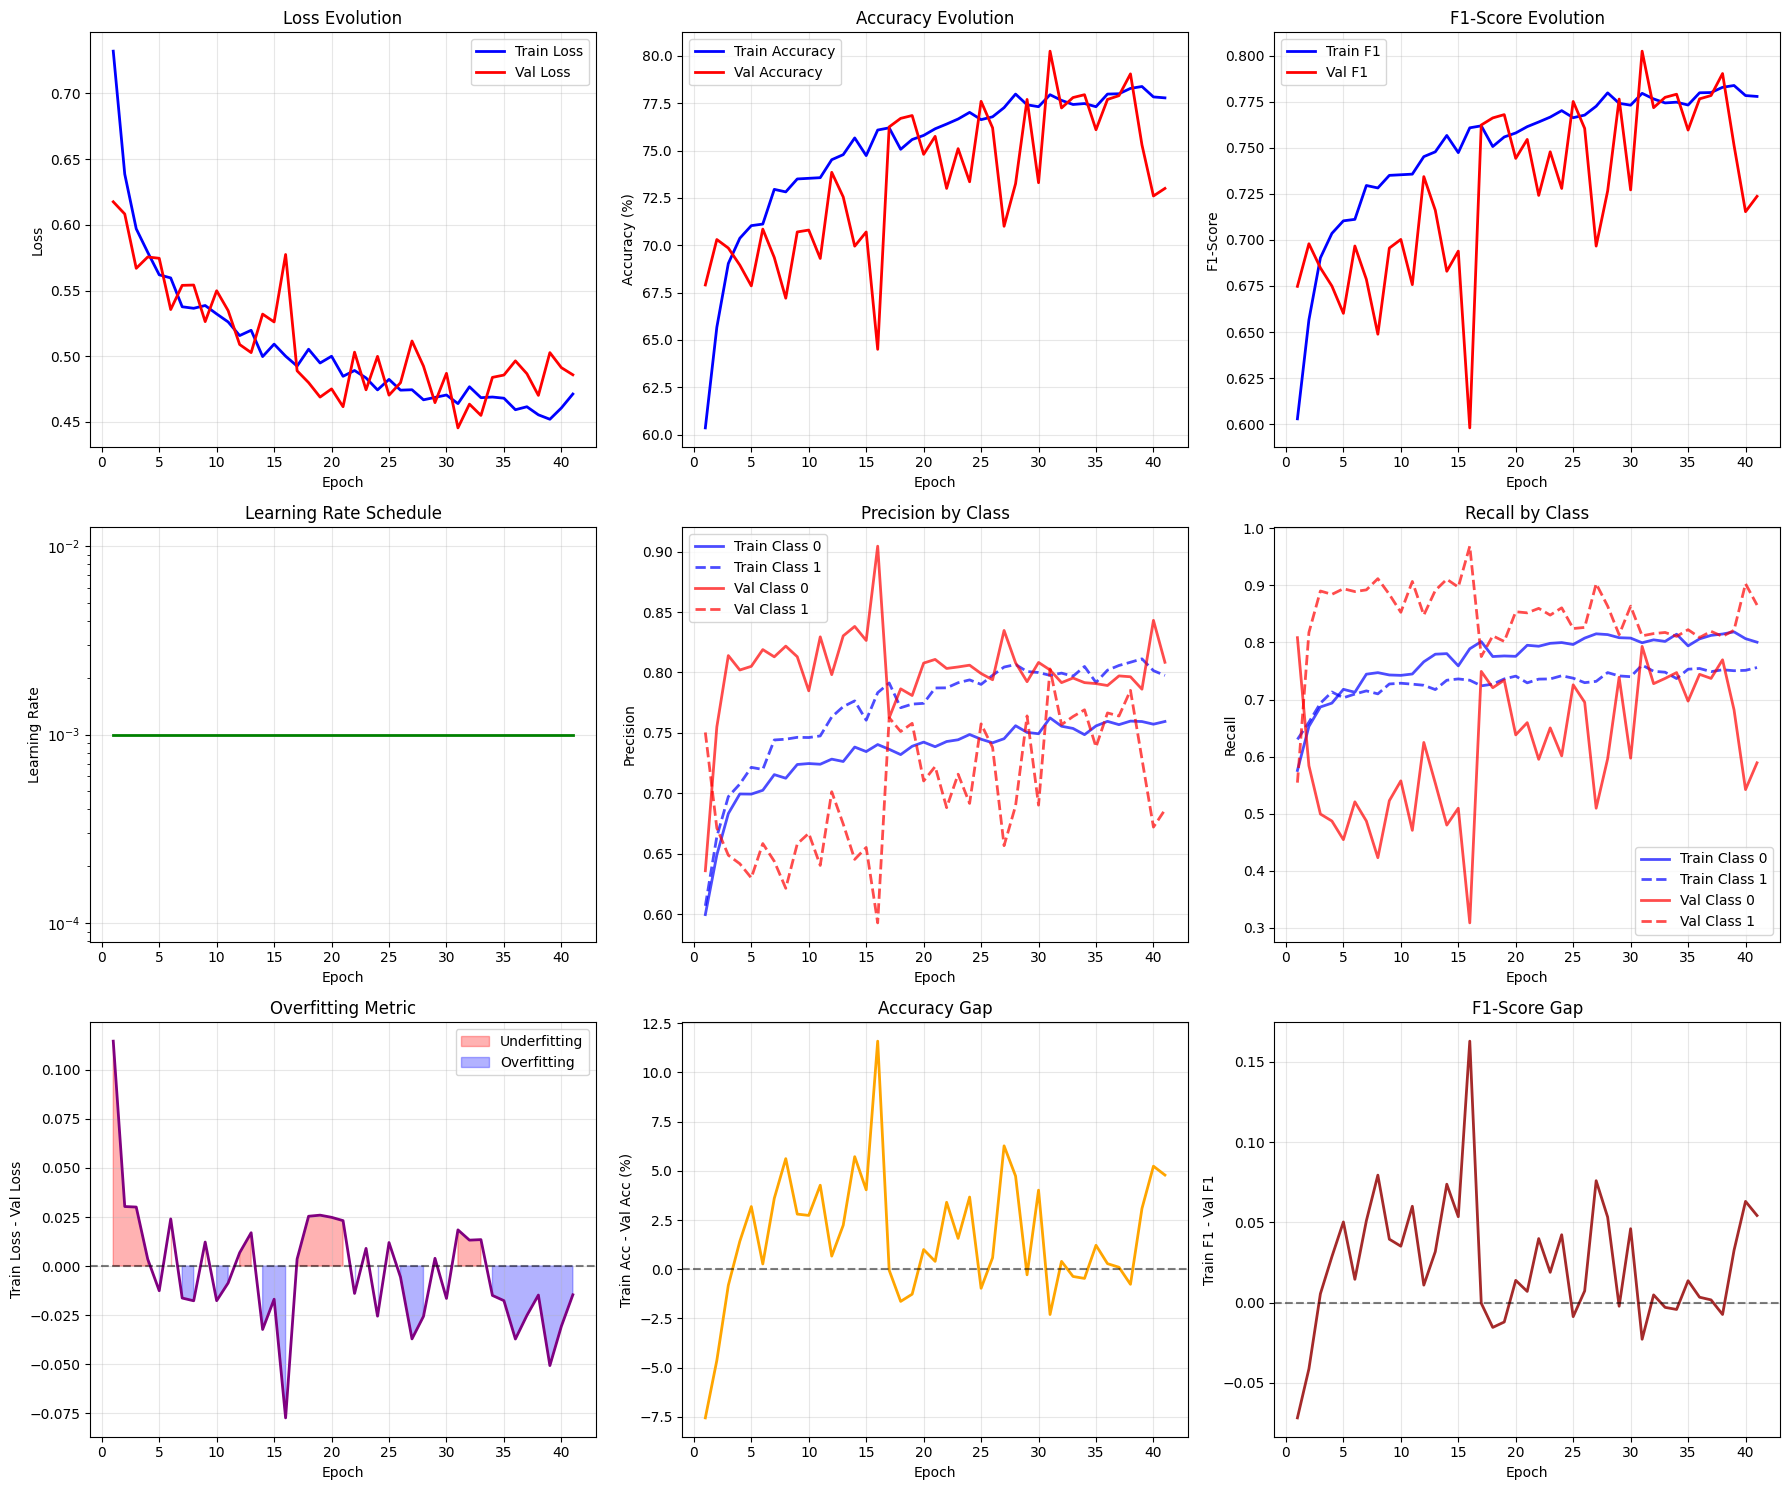

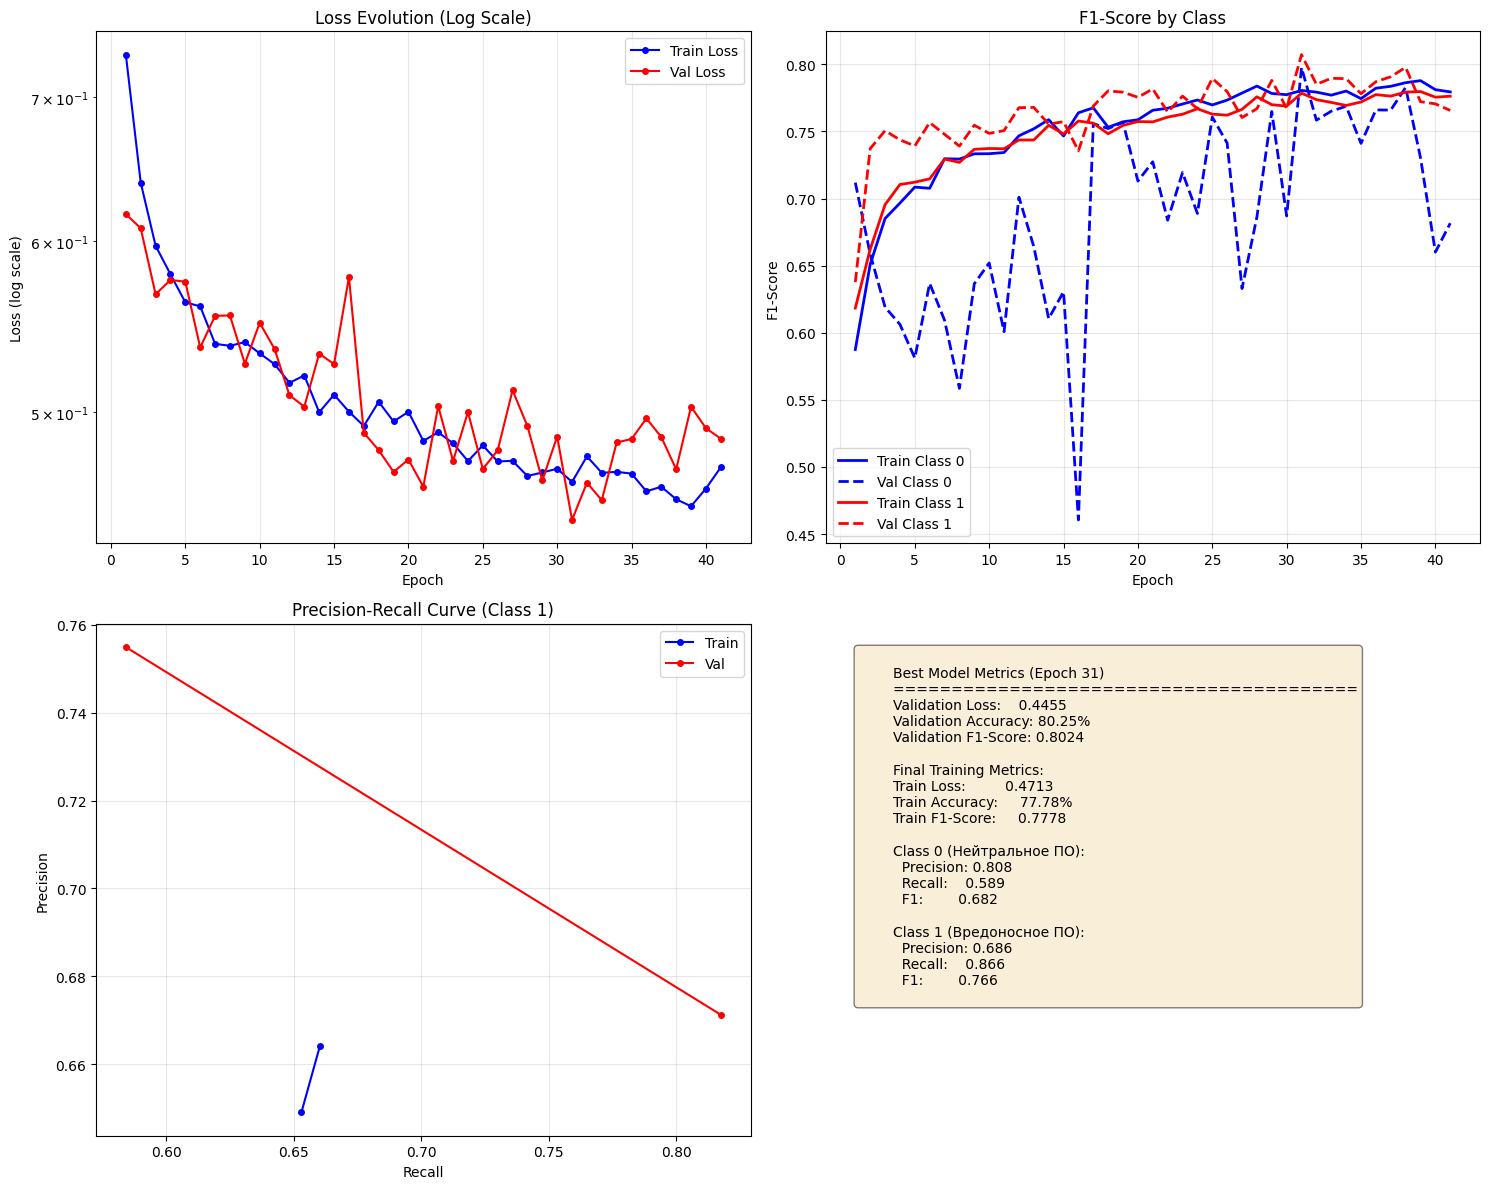


ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ


Testing: 100%|██████████| 32/32 [00:00<00:00, 136.14it/s]



Классификационный отчет:
                          precision    recall  f1-score   support

Нейтральное ПО (Class 0)     0.8120    0.6208    0.7036       981
Вредоносное ПО (Class 1)     0.7024    0.8616    0.7739      1019

                accuracy                         0.7435      2000
               macro avg     0.7572    0.7412    0.7388      2000
            weighted avg     0.7562    0.7435    0.7394      2000


Матрица ошибок:
[[609 372]
 [141 878]]

Дополнительные метрики:
Чувствительность (Sensitivity/Recall): 0.8616
Специфичность (Specificity): 0.6208
Precision (Class 1): 0.7024
F1-Score (Class 1): 0.7739
False Positive Rate: 0.3792
False Negative Rate: 0.1384

Итоговые метрики на тестовой выборке:
Test Loss: 0.4832
Test Accuracy: 74.35%


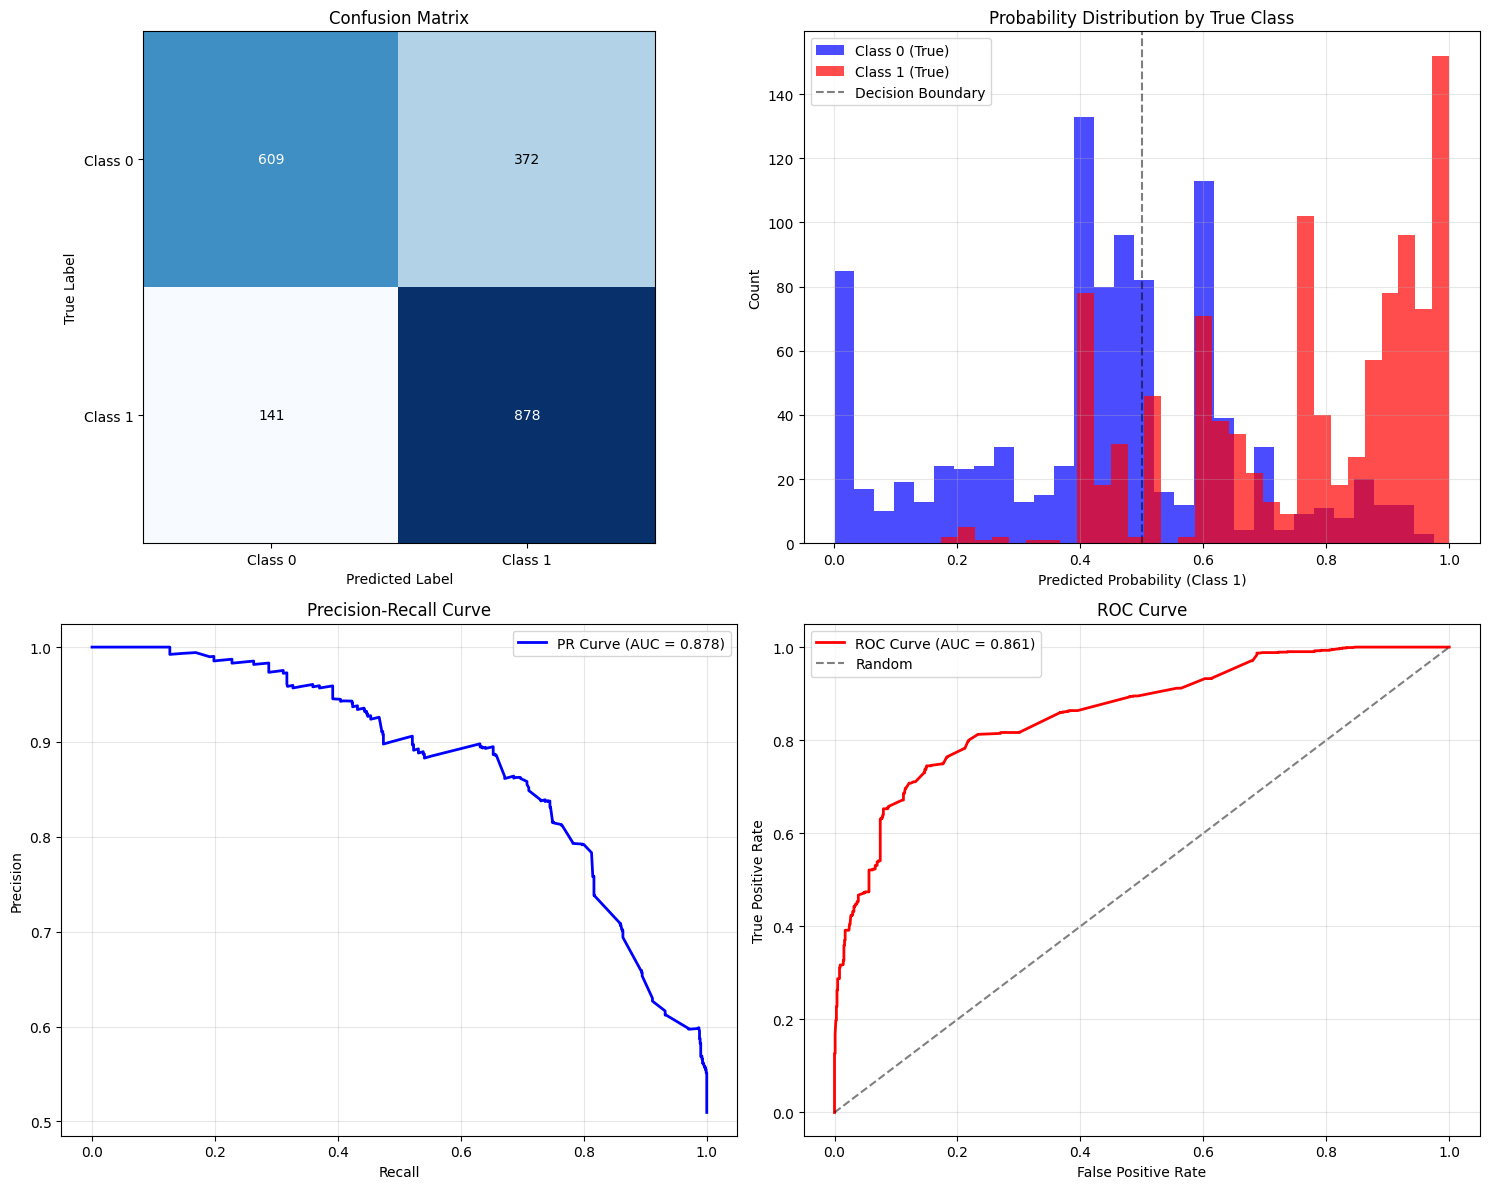

In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_train_scaled.shape[1]
model = MalwareClassifier(input_dim=input_dim, hidden_dims=[256, 128, 64])

trainer = Trainer(model, device, model_name='malware_classifier')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=50
)

trainer.train(
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=50,
    patience=10,
    checkpoint_freq=5
)

# Визуализация
trainer.plot_training_history()

# Тестирование
test_loss, test_acc, predictions, targets, probabilities = trainer.evaluate_test(
    test_loader, criterion
)